In [482]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import torch.utils.data as data
import torchvision.transforms as transforms

# SciKit
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
# Python
import pandas as pd
import numpy as np
import time

# Graphing
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


# utils
from utils import *

# Device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [483]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [484]:
# ML Parameters
lr = 5e-4
min_lr = 1e-3
epochs = 800
batch_size = 512
clip_grad = 3
# Data Parameters
data_seq_len = [120, 30, 100, 100, 40]
data_n_features = 1
data_embedding_dim = 64

In [485]:
#load train data
df_sensorA_normal = pd.read_csv('data/sensor_A_normal.csv')
df_sensorB_normal = pd.read_csv('data/sensor_B_normal.csv')
df_sensorC_normal = pd.read_csv('data/sensor_C_normal.csv')
df_sensorD_normal = pd.read_csv('data/sensor_D_normal.csv')
df_sensorE_normal = pd.read_csv('data/sensor_E_normal.csv')
print(len(df_sensorA_normal))
df_train = [df_sensorA_normal, df_sensorB_normal, df_sensorC_normal, df_sensorD_normal, df_sensorE_normal]

# load val data
df_sensorA_public = pd.read_csv('data/sensor_A_public.csv')
df_sensorB_public = pd.read_csv('data/sensor_B_public.csv')
df_sensorC_public = pd.read_csv('data/sensor_C_public.csv')
df_sensorD_public = pd.read_csv('data/sensor_D_public.csv')
df_sensorE_public = pd.read_csv('data/sensor_E_public.csv')
print(len(df_sensorA_public))
df_test = [df_sensorA_public, df_sensorB_public, df_sensorC_public, df_sensorD_public, df_sensorE_public]

# load test data
df_sensorA_private = pd.read_csv('data/sensor_A_private.csv')
df_sensorB_private = pd.read_csv('data/sensor_B_private.csv')
df_sensorC_private = pd.read_csv('data/sensor_C_private.csv')
df_sensorD_private = pd.read_csv('data/sensor_D_private.csv')
df_sensorE_private = pd.read_csv('data/sensor_E_private.csv')
print(len(df_sensorA_private))
df_private = [df_sensorA_private, df_sensorB_private, df_sensorC_private, df_sensorD_private, df_sensorE_private]

2875
4000
4000


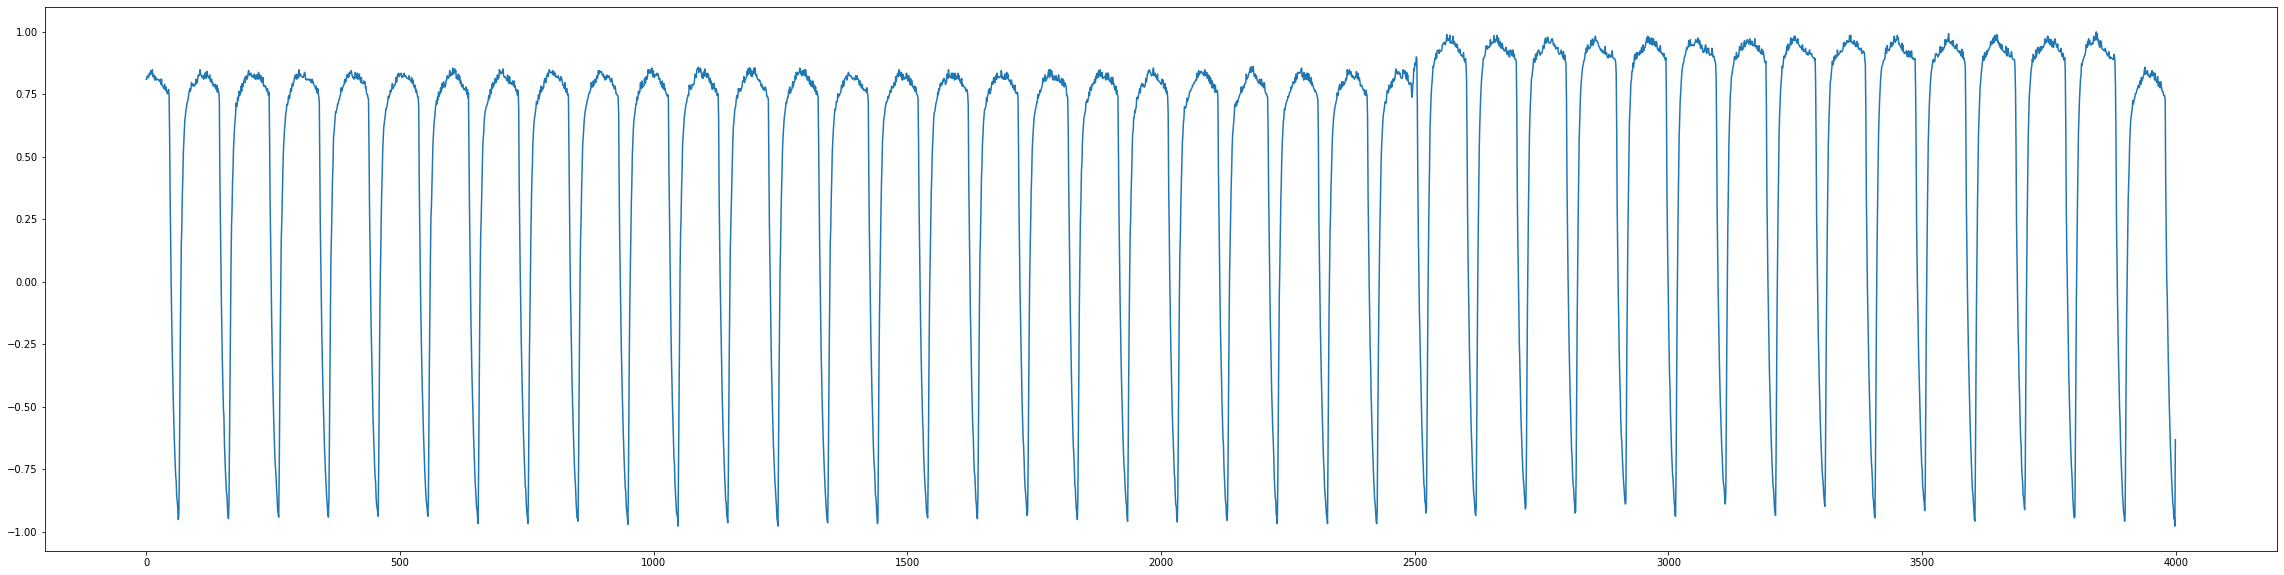

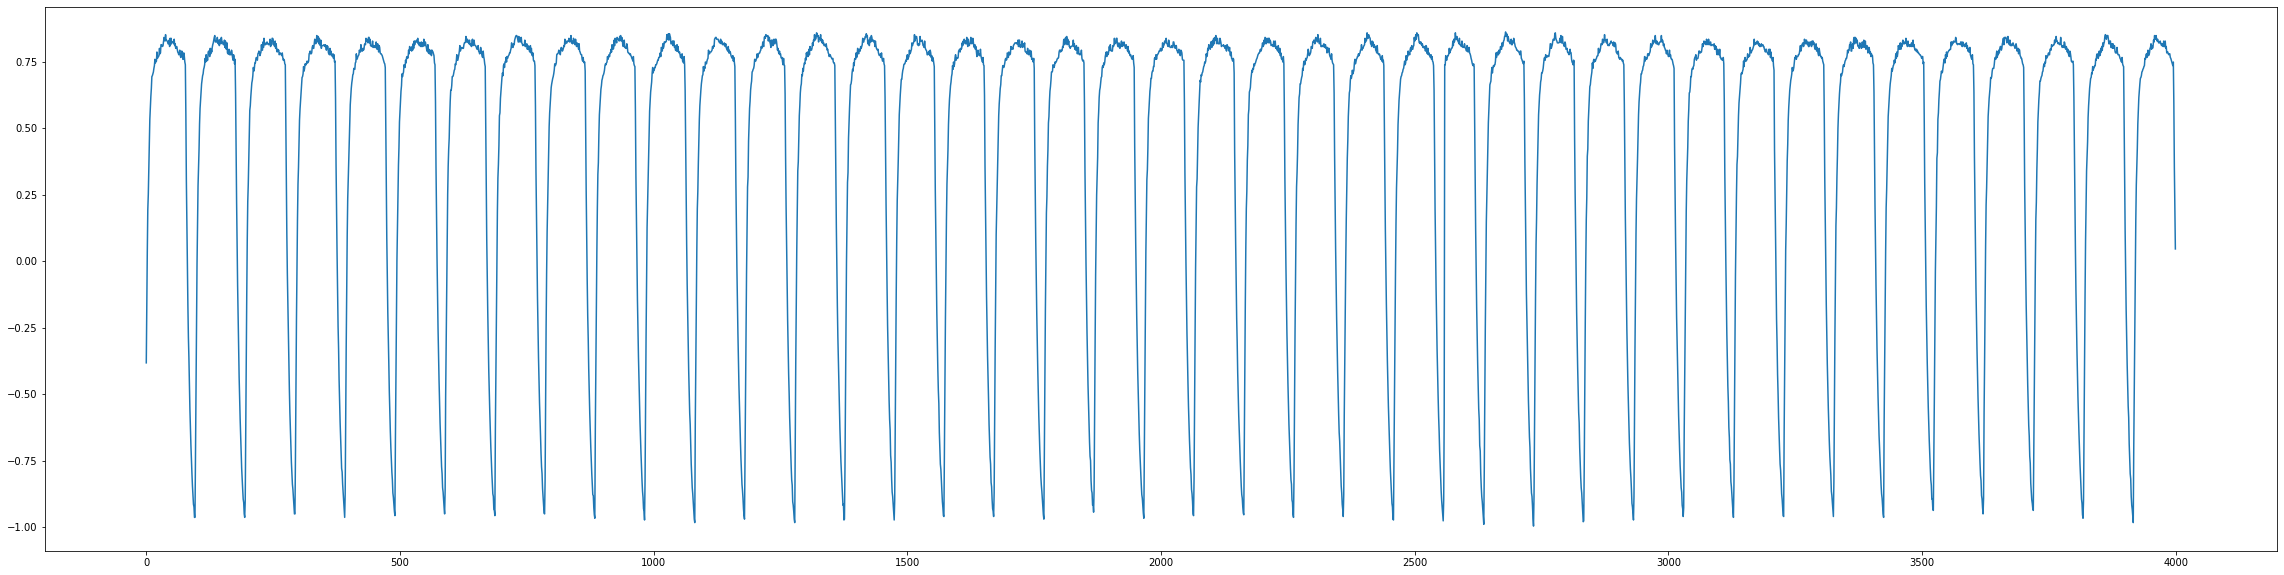

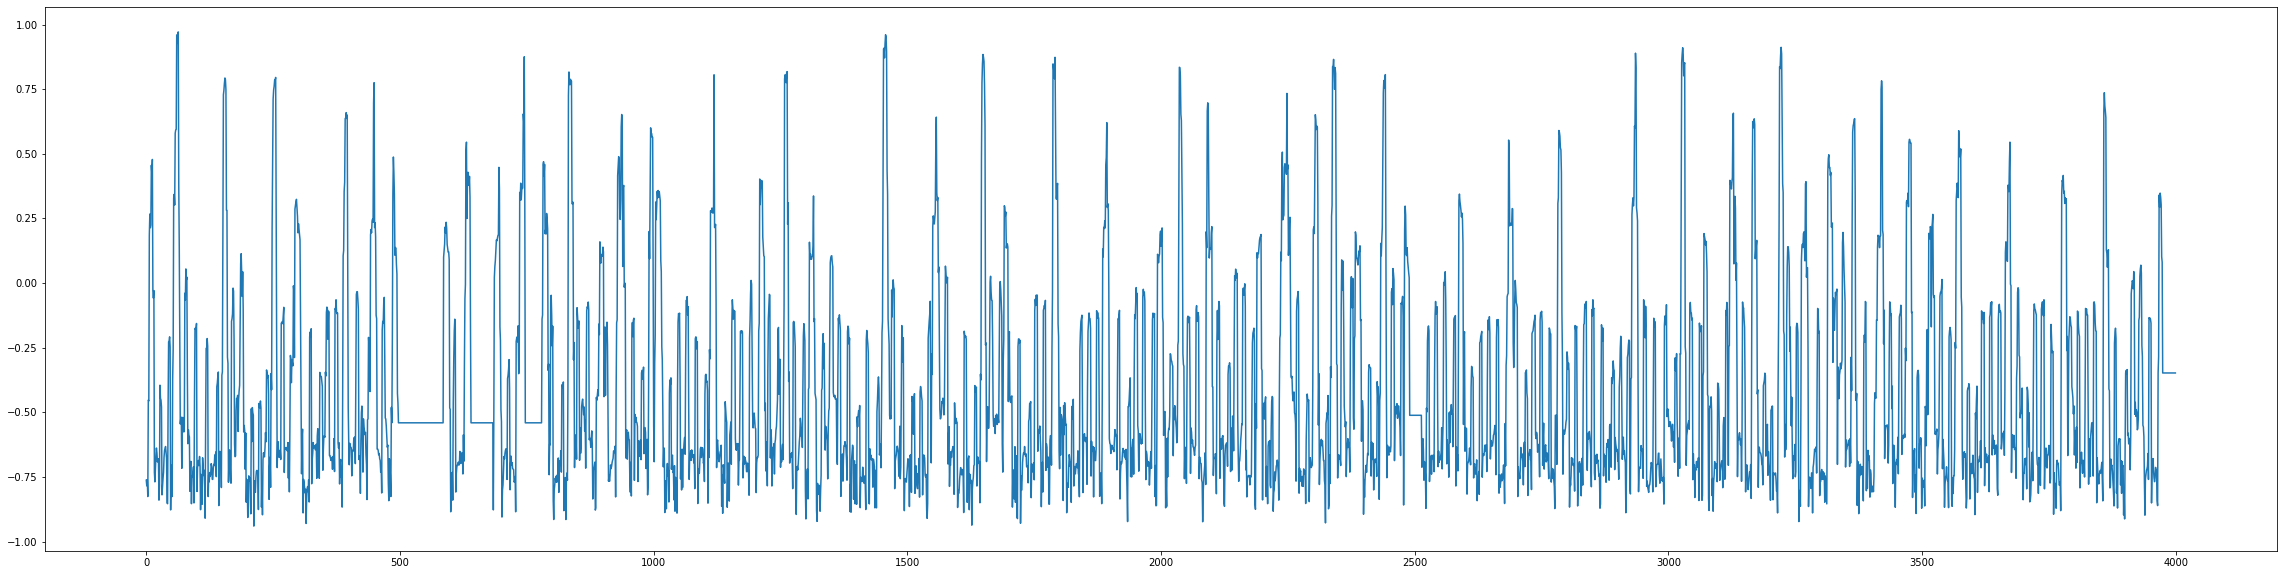

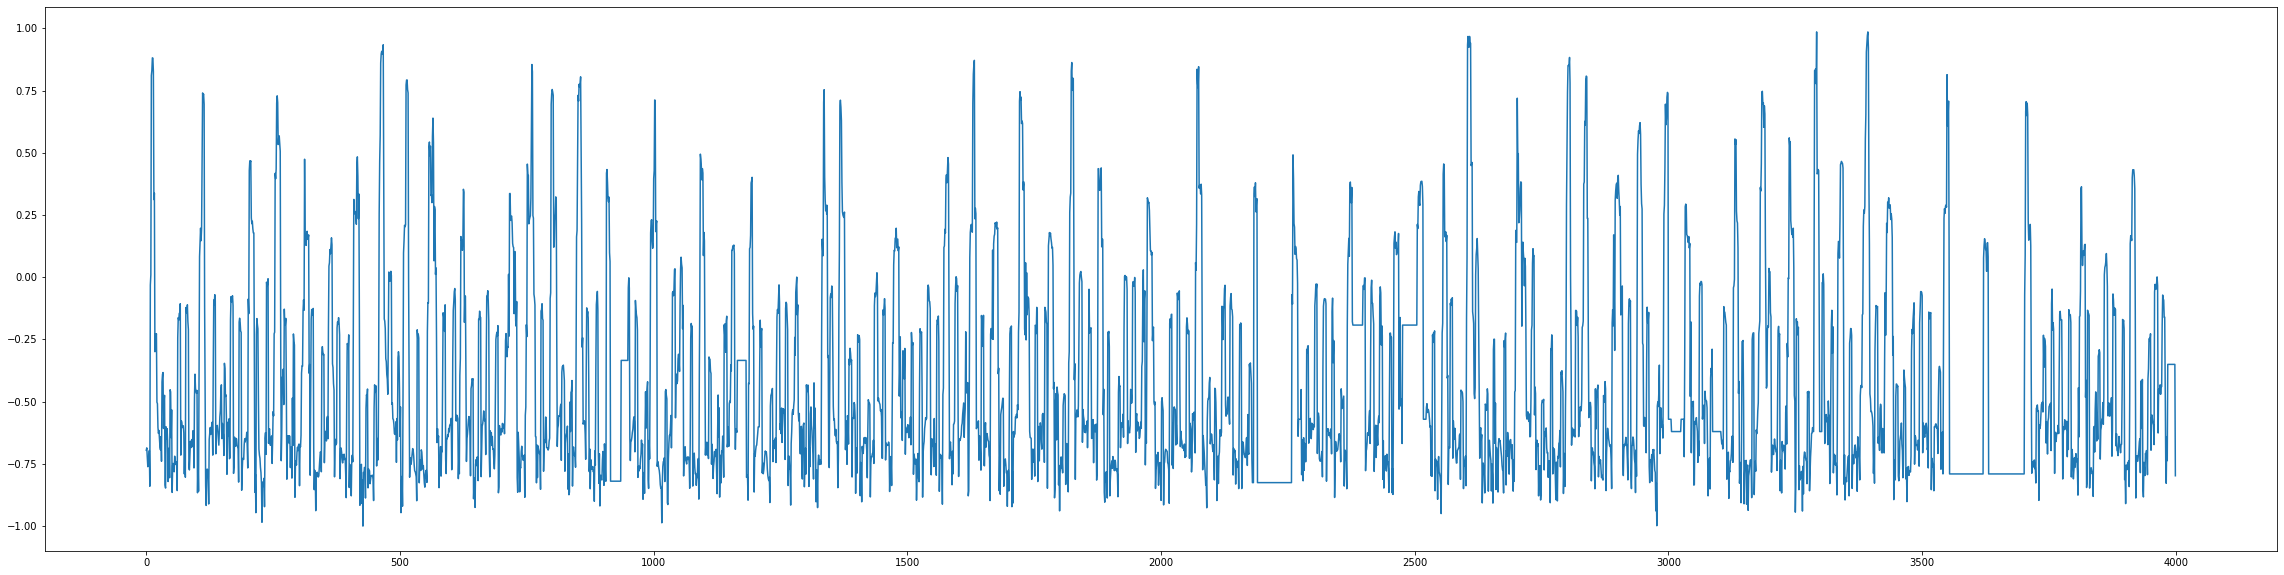

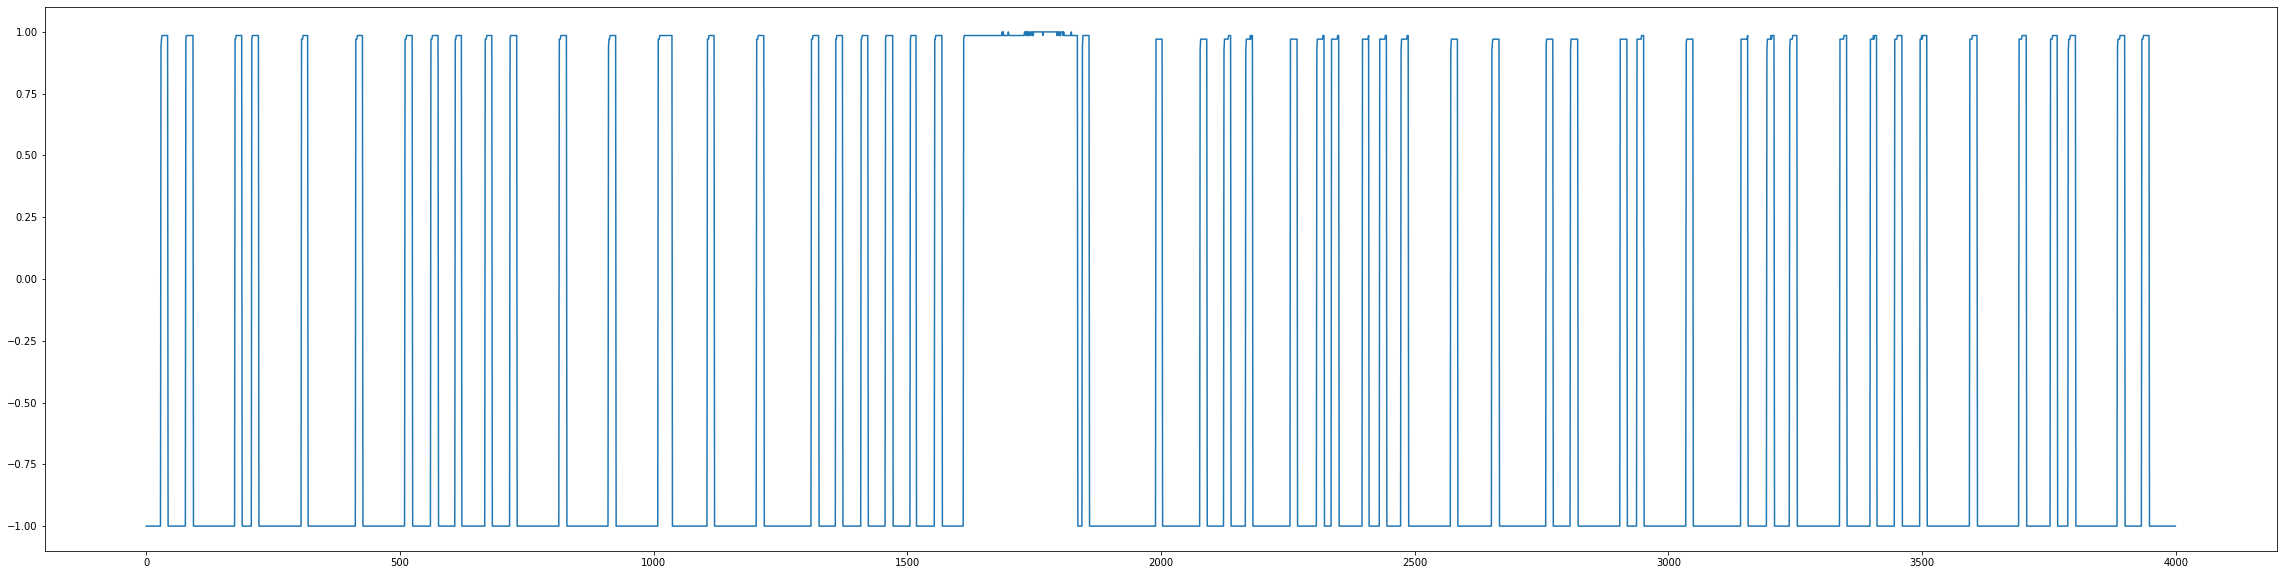

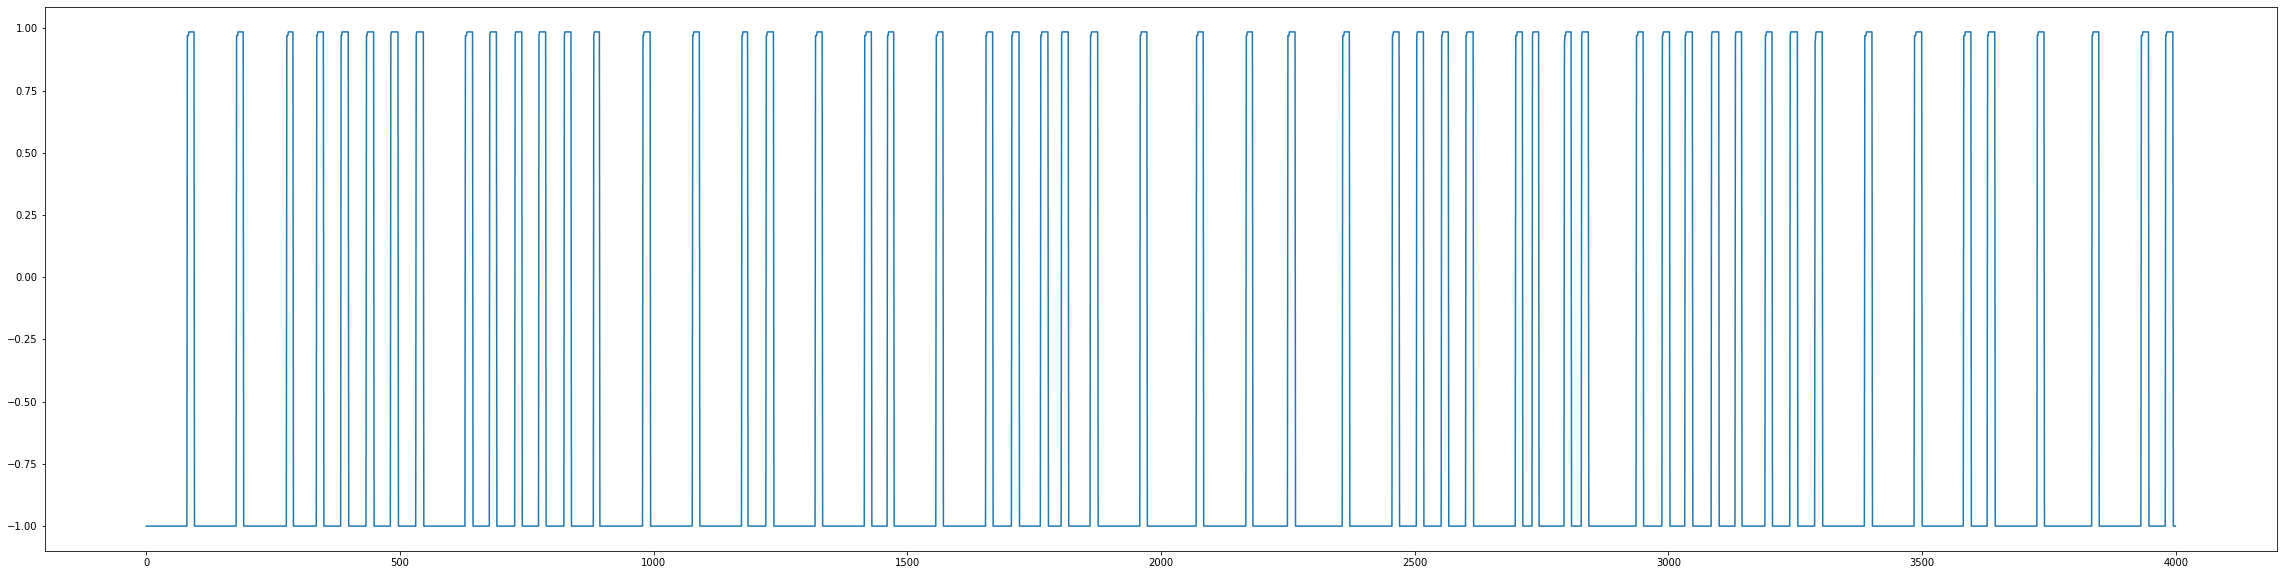

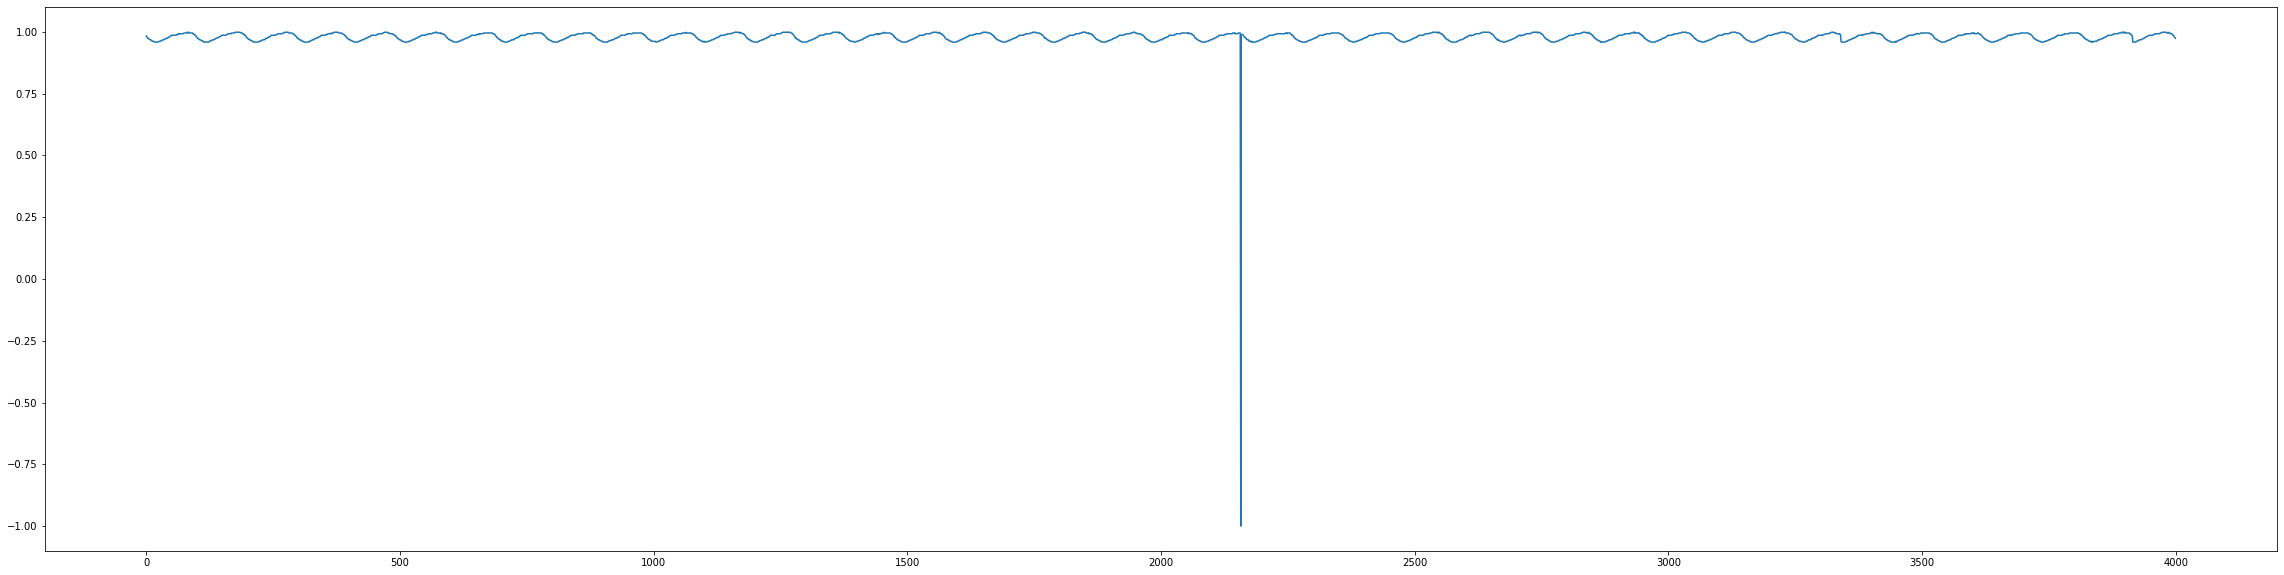

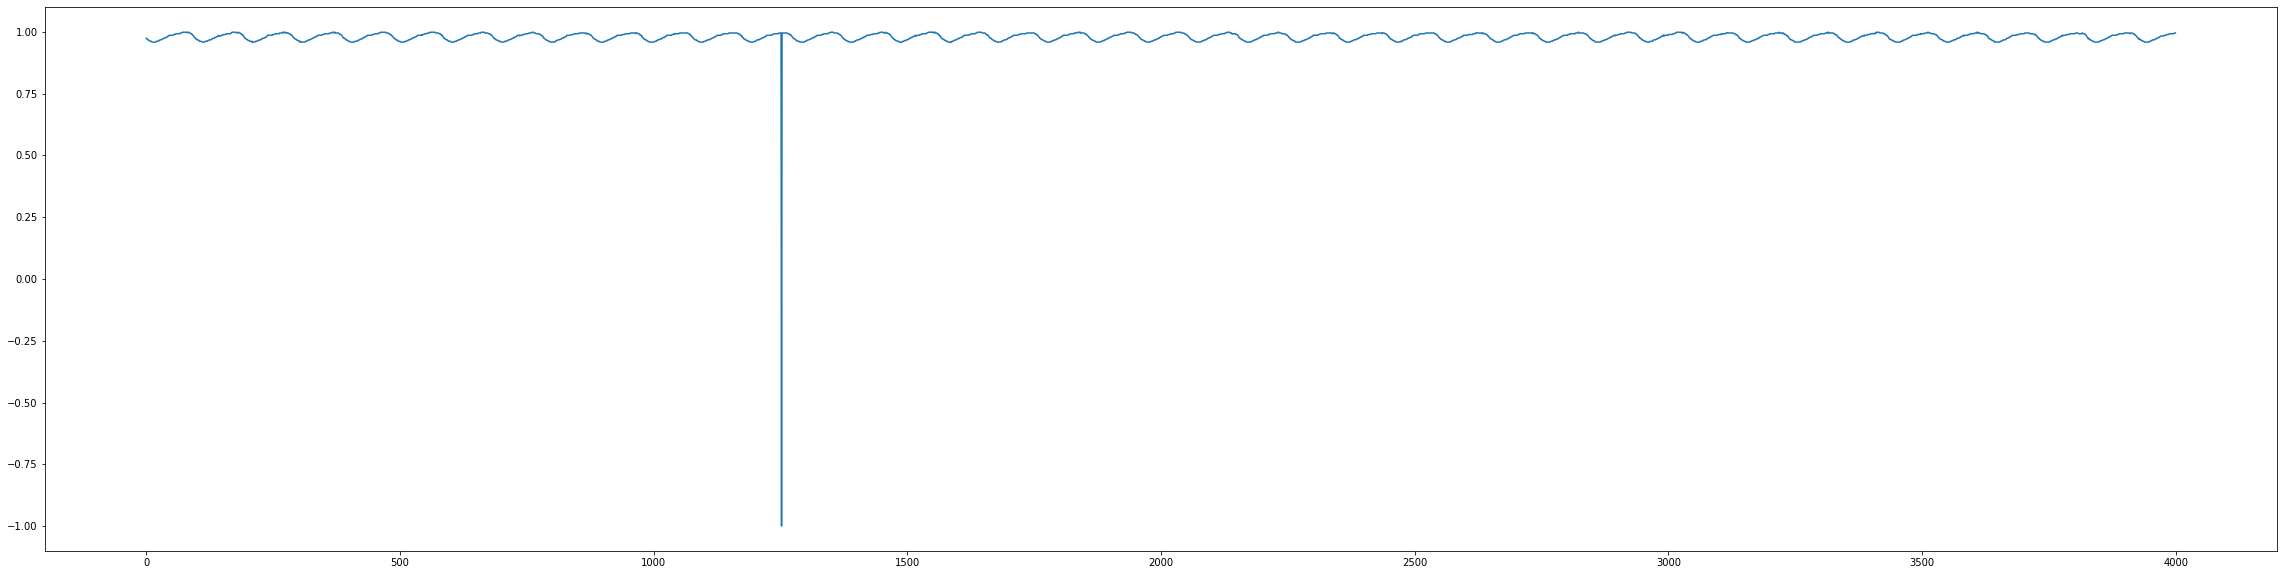

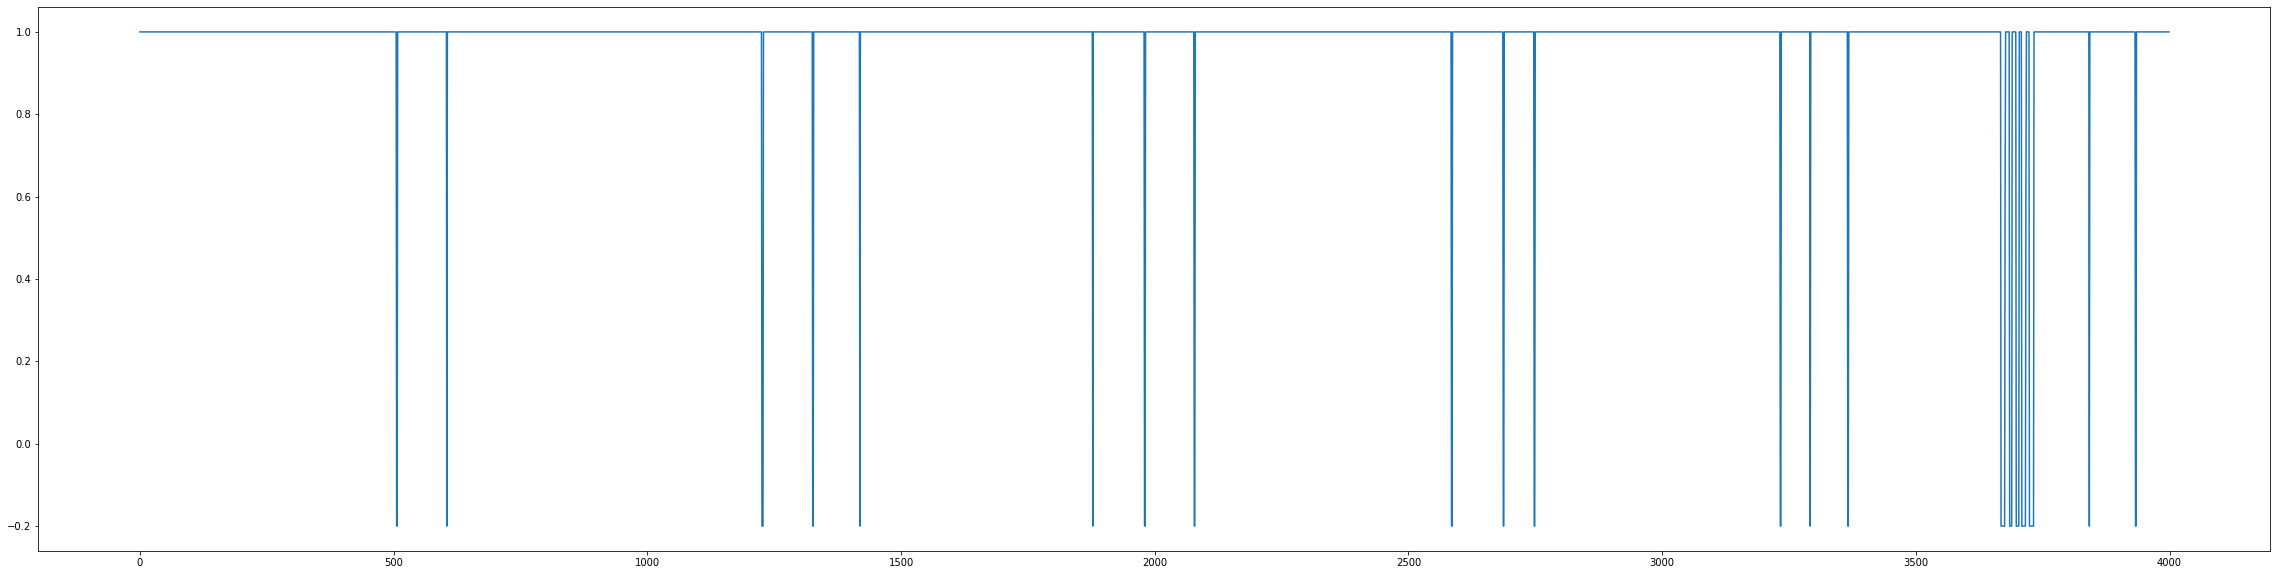

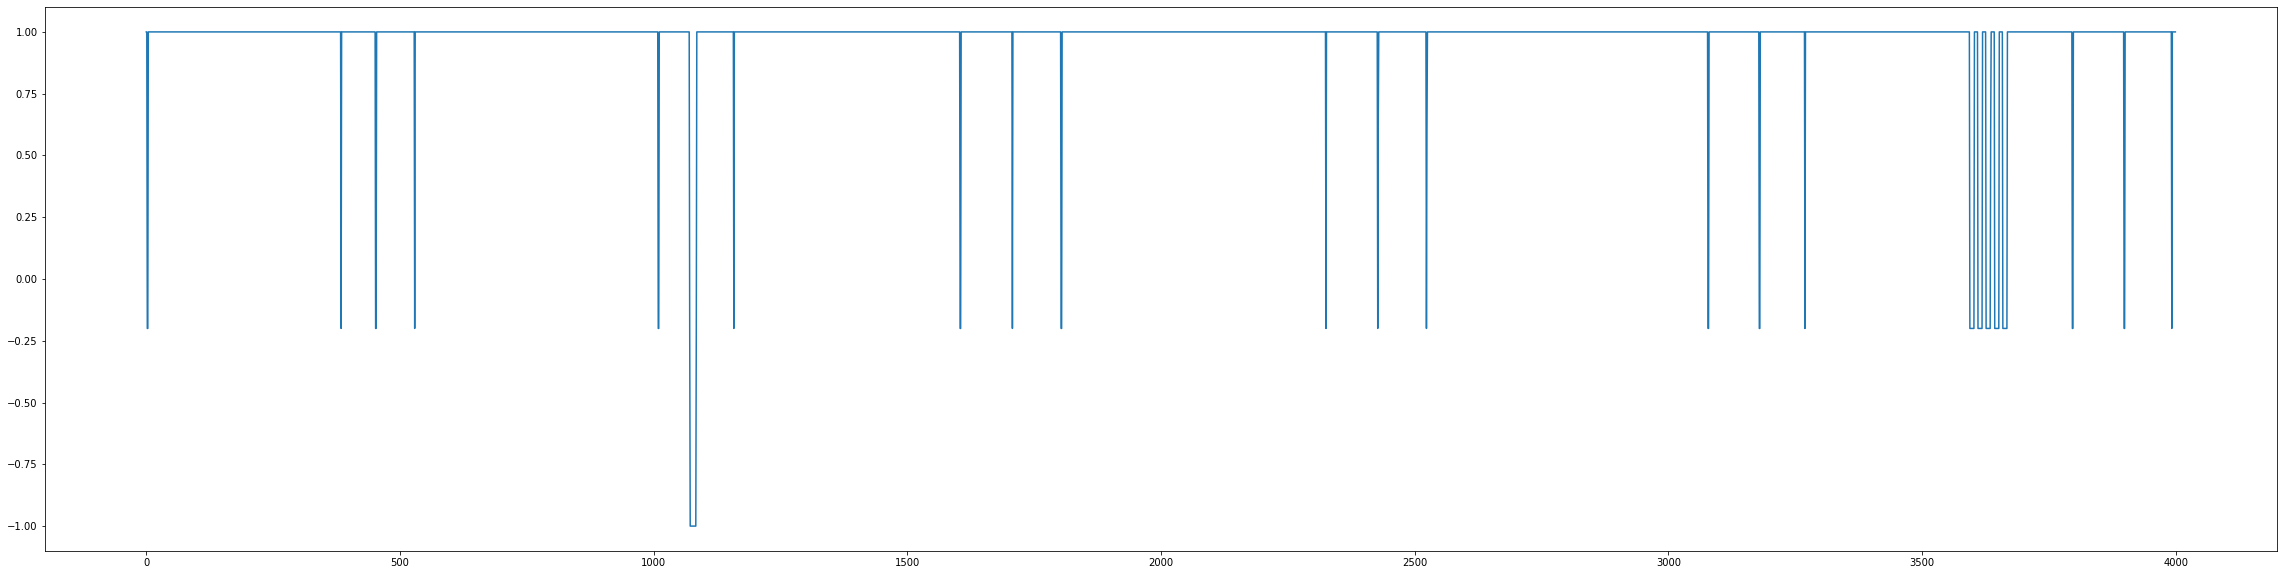

In [486]:
# plot
plt.figure(figsize=(40,10))
plt.plot(df_sensorA_public.index, df_sensorA_public.iloc[:, 0])
plt.show()
plt.figure(figsize=(40,10))
plt.plot(df_sensorA_private.index, df_sensorA_private.iloc[:, 0])
plt.show()
plt.figure(figsize=(40,10))
plt.plot(df_sensorB_public.index, df_sensorB_public.iloc[:, 0])
plt.show()
plt.figure(figsize=(40,10))
plt.plot(df_sensorB_private.index, df_sensorB_private.iloc[:, 0])
plt.show()
plt.figure(figsize=(40,10))
plt.plot(df_sensorC_public.index, df_sensorC_public.iloc[:, 0])
plt.show()
plt.figure(figsize=(40,10))
plt.plot(df_sensorC_private.index, df_sensorC_private.iloc[:, 0])
plt.show()
plt.figure(figsize=(40,10))
plt.plot(df_sensorD_public.index, df_sensorD_public.iloc[:, 0])
plt.show()
plt.figure(figsize=(40,10))
plt.plot(df_sensorD_private.index, df_sensorD_private.iloc[:, 0])
plt.show()
plt.figure(figsize=(40,10))
plt.plot(df_sensorE_public.index, df_sensorE_public.iloc[:, 0])
plt.show()
plt.figure(figsize=(40,10))
plt.plot(df_sensorE_private.index, df_sensorE_private.iloc[:, 0])
plt.show()

In [487]:
class SensorDataset(data.Dataset):
    """
        Support class for the loading and batching of sequences of samples

        Args:
            dataset (Tensor): Tensor containing all the samples
            sequence_length (int): length of the analyzed sequence by the LSTM
            transforms (object torchvision.transform): Pytorch's transforms used to process the data
    """
    ##  Constructor
    def __init__(self, df, seq_len=1, transform=None):
        self.dataset = df
        self.seq_len = seq_len
        self.transforms = transform

    ##  Override total dataset's length getter
    def __len__(self):
        return self.dataset.__len__()
    
    ## Ex. idx : 3 , seq : 1, 2, 3
    def idx_last(self, idx):
        if idx+1 < self.seq_len:
            if self.transforms is not None:    
                item = torch.zeros(self.seq_len, self.dataset[0].__len__())
                item[self.seq_len-idx-1:] = self.transforms(self.dataset[:idx+1])
                return item, item
            else:
                item = []
                item[self.seq_len-idx-1:] = self.dataset[idx:self.seq_len]
                return item, item

        else:
            if self.transforms is not None:
                return self.transforms(self.dataset[idx-self.seq_len+1:idx+1]), self.transforms(self.dataset[idx-self.seq_len+1:idx+1])
            else:
                return self.dataset[idx-self.seq_len+1:idx+1], self.dataset[idx-self.seq_len+1:idx+1]
    ## Ex. idx = 3, seq = 1, 2, 3, 4, 5, 6
    def idx_middle(self, idx):
        half_len = int(self.seq_len/2)
        if idx < self.seq_len/2:        
            if self.transforms is not None:
                item = torch.zeros(self.seq_len, self.dataset[0].__len__())
                item[half_len-idx:] = self.transforms(self.dataset[:idx+half_len])
                return item, item
            else:
                item = []
                item[half_len-idx:] = self.dataset[:idx+half_len]
                return item, item
        elif idx + self.seq_len/2 + 1 > self.__len__():
            if self.transforms is not None:
                item = torch.zeros(self.seq_len, self.dataset[0].__len__())
                item[:self.__len__()-idx+half_len] = self.transforms(self.dataset[idx-half_len:])
                return item, item
            else:
                item = []
                item[:self.__len__()-idx+half_len] = self.dataset[idx-half_len:]
                return item, item
        else:
            if self.transforms is not None:
                return self.transforms(self.dataset[idx-half_len:idx+half_len]), self.transforms(self.dataset[idx-half_len:idx+half_len])
            else:
                return self.dataset[idx-half_len:idx+half_len], self.dataset[idx-half_len:idx+half_len]
    ##  Override single items' getter
    def __getitem__(self, idx):
        #return self.idx_last(idx)
        return self.idx_middle(idx)
                
# Helper for transforming the data from a list to Tensor
def listToTensor(list):
    tensor = torch.empty(list.__len__(), list[0].__len__())
    for i in range(list.__len__()):
        tensor[i, :] = torch.from_numpy(list[i])
    return tensor 

# transform
data_transform = transforms.Lambda(lambda x: listToTensor(x))  

In [488]:

# Dataset Objects
train_dataset = []
for i, df in enumerate(df_train):
    data = np.array(df.iloc[:, 0].values).astype(float).reshape(-1, 1)
    train_dataset.append(SensorDataset(data, seq_len=data_seq_len[i], transform = data_transform))
val_dataset = []
for i, df in enumerate(df_test):
    data = np.array(df.iloc[:401, 0].values).astype(float).reshape(-1, 1)
    val_dataset.append(SensorDataset(data, seq_len=data_seq_len[i], transform = data_transform))
private_dataset = []
for i, df in enumerate(df_private):
    data = np.array(df.iloc[:, 0].values).astype(float).reshape(-1, 1)
    private_dataset.append(SensorDataset(data, seq_len=data_seq_len[i], transform = data_transform))

# Pytorch DataLoader objects
train_loader = []
for dataset in train_dataset:
    train_loader.append(DataLoader(dataset, batch_size=batch_size, shuffle=False))
val_loader = []
for dataset in val_dataset:
    val_loader.append(DataLoader(dataset, batch_size=batch_size, shuffle=False))
private_loader = []
for dataset in private_dataset:
    private_loader.append(DataLoader(dataset, batch_size=batch_size, shuffle=False))

In [489]:
class LSTMEncoder(nn.Module):
    
    def __init__(self, seq_len, n_features, embedding_dim):
        super(LSTMEncoder, self).__init__()
        
        # Parameters
        self.seq_len = seq_len
        self.n_features = n_features
        self.embedding_dim = embedding_dim
        self.hidden_dim = 2*embedding_dim
        
        # Neural Network Layers
        self.lstm1 = nn.LSTM(self.n_features, self.hidden_dim, num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(self.hidden_dim, self.embedding_dim, num_layers=1, batch_first=True)
    
    def forward(self, i): 
        i, _ = self.lstm1(i)               # from (batch, seq_len, n_features) to (batch, seq_len, hidden_dim)
        i, (hidden_n, _) = self.lstm2(i)   # from (batch, seq_len, hidden_dim) to (batch, seq_len, embedding_dim)
        return hidden_n                    # hidden_n shape: (num_layers*num_directions, batch, embedding_dim)


class LSTMDecoder(nn.Module):

    def __init__(self, seq_len, embedding_dim, n_features=1):
        super(LSTMDecoder, self).__init__()

        # Parameters
        self.seq_len = seq_len
        self.embedding_dim = embedding_dim
        self.hidden_dim = 2*embedding_dim
        self.n_features = n_features
        
        # Neural Network Layers
        self.lstm1 = nn.LSTM(self.embedding_dim, self.embedding_dim, num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(self.embedding_dim, self.hidden_dim, num_layers=1, batch_first=True)
        self.output_layer = nn.Linear(self.hidden_dim, n_features)
        
    def forward(self, i):
        # Do padding
        i = i.repeat(self.seq_len, 1, 1)                       # repeat (1, embedding_dim) to (seq_len, embedding_dim)
        i = i.reshape((-1, self.seq_len, self.embedding_dim))  # reshape to (batch, seq_len, embedding_dim)
        
        # Traverse neural layers
        i, _ = self.lstm1(i)      # from (batch, seq_len, embedding_dim) to (batch, seq_len, embedding_dim)
        i, _ = self.lstm2(i)      # from (batch, seq_len, embedding_dim) to (batch, seq_len, hidden_dim)
        i = self.output_layer(i)  # from (batch, seq_len, hidden_dim) to (batch, seq_len, n_features)
        
        return i


class LSTMAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(LSTMAutoencoder, self).__init__()
        self.encoder = LSTMEncoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = LSTMDecoder(seq_len, embedding_dim, n_features).to(device)
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)    
    def forward(self, i):
        i = self.encoder(i)
        i = self.decoder(i)
        return i

In [490]:
def training(model, optimizer, trainset_iterator, validationset_iterator, epoch):
    # Define model1 for E1
    lr_schedule = cosine_scheduler(
        lr * batch_size / 256,
        min_lr,
        epochs, len(trainset_iterator),
        warmup_epochs=10,
    )
    train_losses, test_losses = [], []
    criterion = nn.L1Loss(reduction='sum').to(device)

    for epoch in range(epoch):
        
        print("Epoch %d training started ..." % epoch)
        start_time = time.time()
        
        # Enter Train Mode
        model.train()     
        train_loss = 0
        for it, (ii, _) in enumerate(trainset_iterator):
            #print(ii)
            ii = ii.to(device)              # move to GPU if necessary
            it = len(trainset_iterator) * epoch + it  # global training iteration
            for i, param_group in enumerate(optimizer.param_groups):
                param_group["lr"] = lr_schedule[it]
            optimizer.zero_grad()           # generate prediction
            preds = model(ii)               # generate prediction
            loss = criterion(preds, ii)     # calculate loss
            loss.backward()                 # back propagation of gradients and update weights
            if clip_grad:
                param_norms = clip_gradients(model, clip_grad)
            optimizer.step()                # update optimizer
            train_loss += loss.item()       # record training losses

        # Enter Validation Mode
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for ii, _ in validationset_iterator:
                ii = ii.to(device)          # move to GPU if necessary
                preds = model(ii)           # generate prediction
                loss = criterion(preds, ii) # calculate loss
                test_loss += loss           # record validation testing losses
        
        end_time = time.time()
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        print("Epoch %d completed - train_loss: %f , test_loss: %f" % (epoch, train_loss, test_loss))
        print("Epoch %d training time: %f" %(epoch, (end_time - start_time)))
    
    return train_losses, test_losses

In [578]:
def predict(model, dataset_iterator, i):
    preds, losses = np.array([]), np.array([])
    criterion = nn.L1Loss(reduction='none').to(device)
    
    # Enter Validation Mode
    model = model.eval()
    with torch.no_grad():
        for ii, _ in dataset_iterator:
            # move to GPU if necessary
            ii = ii.to(device)
            
            # generate prediction
            pred = model(ii)
            
            # calculate loss
            loss = criterion(pred, ii)
            
            # record predictions
            #preds = np.append(preds, pred[:, int(data_seq_len[i]/2), :].cpu().numpy())
            preds = np.vstack((preds, pred.cpu().numpy())) if preds.size else pred.cpu().numpy()
            # record mean loss of each sample
            loss = loss.reshape((-1, int(data_seq_len[i]))).cpu().numpy()  # from (batch, seq_len, n_feature) to (batch, seq_len)
            losses = np.append(losses, [np.sum(i) for i in loss])  # sum of all seq_len losses into one loss
    preds = np.array(preds)
    #print(preds)
    preds = preds.reshape((-1, data_seq_len[i]))  # reshape to (batch, seq_len)
    return preds, losses

In [492]:
for i in range(5):
    model = LSTMAutoencoder(data_seq_len[i], data_n_features, data_embedding_dim)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # Training:
    train_losses, test_losses = training(model, optimizer, train_loader[i], val_loader[i], epochs)

    # Saving trained models
    torch.save(model, f'./model/sensor_model_{i}.pth')

Epoch 0 training started ...
Epoch 0 completed - train_loss: 264107.769531 , test_loss: 29909.804688
Epoch 0 training time: 3.499424
Epoch 1 training started ...
Epoch 1 completed - train_loss: 259834.316406 , test_loss: 29073.763672
Epoch 1 training time: 3.437692
Epoch 2 training started ...
Epoch 2 completed - train_loss: 249900.964844 , test_loss: 27527.718750
Epoch 2 training time: 3.448440
Epoch 3 training started ...
Epoch 3 completed - train_loss: 231804.363281 , test_loss: 24715.869141
Epoch 3 training time: 3.479967
Epoch 4 training started ...
Epoch 4 completed - train_loss: 193282.144531 , test_loss: 18660.167969
Epoch 4 training time: 3.442905
Epoch 5 training started ...
Epoch 5 completed - train_loss: 221935.972656 , test_loss: 42063.125000
Epoch 5 training time: 3.393538
Epoch 6 training started ...
Epoch 6 completed - train_loss: 186713.869141 , test_loss: 18431.332031
Epoch 6 training time: 3.409176
Epoch 7 training started ...
Epoch 7 completed - train_loss: 139238.3

# Evaluate result on public

In [605]:
# load val data
df_sensorA_public = pd.read_csv('data/sensor_A_public.csv')
df_sensorB_public = pd.read_csv('data/sensor_B_public.csv')
df_sensorC_public = pd.read_csv('data/sensor_C_public.csv')
df_sensorD_public = pd.read_csv('data/sensor_D_public.csv')
df_sensorE_public = pd.read_csv('data/sensor_E_public.csv')
print(len(df_sensorA_public))
df_test = [df_sensorA_public, df_sensorB_public, df_sensorC_public, df_sensorD_public, df_sensorE_public]
target = []
for df in df_test:
    target.append(df.iloc[:, -1].values)
    df.drop(['label'], axis=1)


4000


In [606]:
val_dataset = []
for i, df in enumerate(df_test):
    data_test = np.array(df.iloc[:, 0].values).astype(float).reshape(-1, 1)
    val_dataset.append(SensorDataset(data_test, seq_len=data_seq_len[i], transform = data_transform))
val_loader = []
for dataset in val_dataset:
    val_loader.append(DataLoader(dataset, batch_size=batch_size, shuffle=False))
submission = np.array([])

In [607]:
for i in range(5):
    model = torch.load(f'./model/sensor_model_{i}.pth')
    reconstructed_val, losses_val = predict(model, val_loader[i], i)
    print(reconstructed_val.shape)
    reconstructed_error = np.array([])
    for idx in range(len(val_dataset[i].dataset)):
        error = np.mean(np.abs(reconstructed_val[idx] - val_dataset[i][idx][0].cpu().numpy()))
        reconstructed_error = np.append(reconstructed_error, error)
    print("reconstructed_error:", reconstructed_error.shape)
    print("AUC score:", roc_auc_score(target[i], reconstructed_error))
    submission = np.append(submission, reconstructed_error)
    #submission = np.append(submission, target[i])

[[[0.89521736]
  [0.89327663]
  [0.8944596 ]
  ...
  [0.8990208 ]
  [0.8990041 ]
  [0.89899427]]

 [[0.8957569 ]
  [0.8949218 ]
  [0.89521587]
  ...
  [0.89879227]
  [0.8987848 ]
  [0.8987829 ]]

 [[0.895378  ]
  [0.8951342 ]
  [0.8952222 ]
  ...
  [0.8987358 ]
  [0.89873904]
  [0.8987366 ]]

 ...

 [[0.8948232 ]
  [0.8931675 ]
  [0.8943814 ]
  ...
  [0.89895517]
  [0.89893967]
  [0.8989232 ]]

 [[0.8952958 ]
  [0.89514315]
  [0.8952225 ]
  ...
  [0.898783  ]
  [0.8987786 ]
  [0.8987719 ]]

 [[0.89529127]
  [0.8951594 ]
  [0.8952237 ]
  ...
  [0.8990125 ]
  [0.8990125 ]
  [0.8990124 ]]]
(4000, 120)
reconstructed_error: (4000,)
AUC score: 0.2210016593762762
[[[-0.5704747 ]
  [-0.57039636]
  [-0.5695179 ]
  ...
  [-0.5668094 ]
  [-0.56603485]
  [-0.5653365 ]]

 [[-0.5704153 ]
  [-0.57036006]
  [-0.5695065 ]
  ...
  [-0.566786  ]
  [-0.56600875]
  [-0.56530535]]

 [[-0.57041854]
  [-0.570358  ]
  [-0.5695077 ]
  ...
  [-0.5668126 ]
  [-0.56603664]
  [-0.5653343 ]]

 ...

 [[-0.57042027]
 

# Generate private result

In [608]:
# load private data
df_sensorA_private = pd.read_csv('data/sensor_A_private.csv')
df_sensorB_private = pd.read_csv('data/sensor_B_private.csv')
df_sensorC_private = pd.read_csv('data/sensor_C_private.csv')
df_sensorD_private = pd.read_csv('data/sensor_D_private.csv')
df_sensorE_private = pd.read_csv('data/sensor_E_private.csv')
print(len(df_sensorA_private))
df_private = [df_sensorA_private, df_sensorB_private, df_sensorC_private, df_sensorD_private, df_sensorE_private]

4000


In [609]:
private_dataset = []
for i, df in enumerate(df_private):
    data_private = np.array(df.iloc[:, 0].values).astype(float).reshape(-1, 1)
    private_dataset.append(SensorDataset(data_private, seq_len=data_seq_len[i], transform = data_transform))
private_loader = []
for dataset in private_dataset:
    private_loader.append(DataLoader(dataset, batch_size=batch_size, shuffle=False))

In [610]:
for i in range(5):
    model = torch.load(f'./model/sensor_model_{i}.pth')
    reconstructed_val, losses_val = predict(model, private_loader[i], i)
    print(reconstructed_val.shape)
    reconstructed_error = np.array([])
    for idx in range(len(private_dataset[i].dataset)):
        error = np.mean(np.abs(reconstructed_val[idx] - private_dataset[i][idx][0].cpu().numpy()))
        reconstructed_error = np.append(reconstructed_error, error)
    #print("AUC score:", roc_auc_score(target[i], reconstructed_error))
    submission = np.append(submission, reconstructed_error)
print(submission.shape)


[[[0.8953884 ]
  [0.8951306 ]
  [0.8952306 ]
  ...
  [0.89876026]
  [0.8987818 ]
  [0.898798  ]]

 [[0.89695925]
  [0.8947058 ]
  [0.8952377 ]
  ...
  [0.8990523 ]
  [0.8990609 ]
  [0.89906776]]

 [[0.89355797]
  [0.89411044]
  [0.89473504]
  ...
  [0.8988756 ]
  [0.8988653 ]
  [0.89885557]]

 ...

 [[0.8955823 ]
  [0.89507866]
  [0.895271  ]
  ...
  [0.89902157]
  [0.8990367 ]
  [0.8990463 ]]

 [[0.8924948 ]
  [0.892979  ]
  [0.89415634]
  ...
  [0.89893156]
  [0.8989182 ]
  [0.89890605]]

 [[0.8956658 ]
  [0.8950304 ]
  [0.89522773]
  ...
  [0.89901036]
  [0.89901054]
  [0.8990106 ]]]
(4000, 120)
[[[-0.5705211 ]
  [-0.5704237 ]
  [-0.56954765]
  ...
  [-0.5667975 ]
  [-0.56602436]
  [-0.5653233 ]]

 [[-0.570399  ]
  [-0.5703456 ]
  [-0.5694902 ]
  ...
  [-0.5668217 ]
  [-0.5660455 ]
  [-0.56534237]]

 [[-0.5704094 ]
  [-0.57034993]
  [-0.5694946 ]
  ...
  [-0.5668113 ]
  [-0.5660371 ]
  [-0.56533337]]

 ...

 [[-0.5704173 ]
  [-0.57035524]
  [-0.56949663]
  ...
  [-0.5668233 ]
  [-0.

In [611]:
df_submission = pd.DataFrame(submission, columns=['pred'])
df_submission.insert(0, 'id', df_submission.index)
df_submission
df_submission.to_csv('submission.csv', index=False)